✅ Loaded:
 - Real logs: 13995 rows
 - Sim logs:  127760 rows
 - Real grades: 233 rows
 - Sim grades:  200 rows



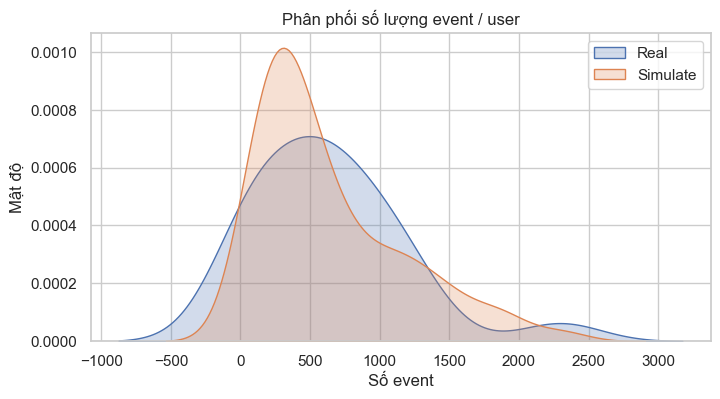

📈 KS-test event/user: statistic=0.1764, p=0.5085
📊 Trung bình event/user: real=636.14, sim=638.80



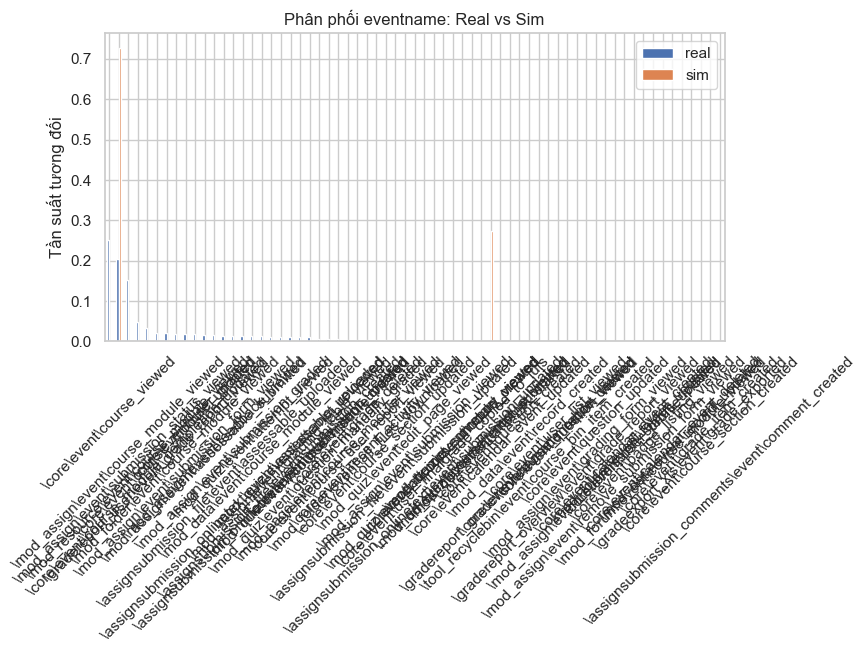

🔹 JS divergence (eventname) = inf



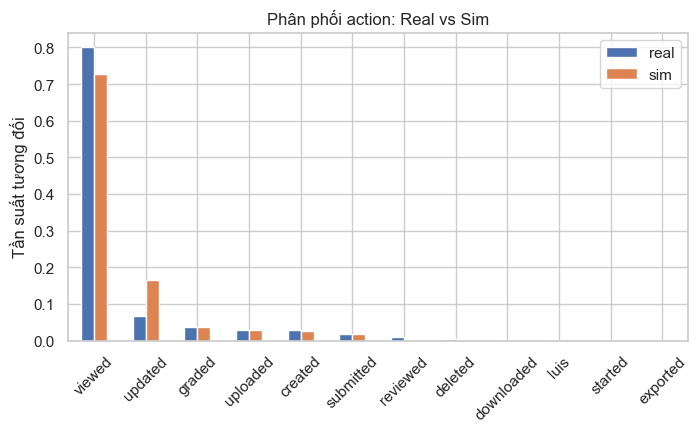

🔹 JS divergence (action) = inf



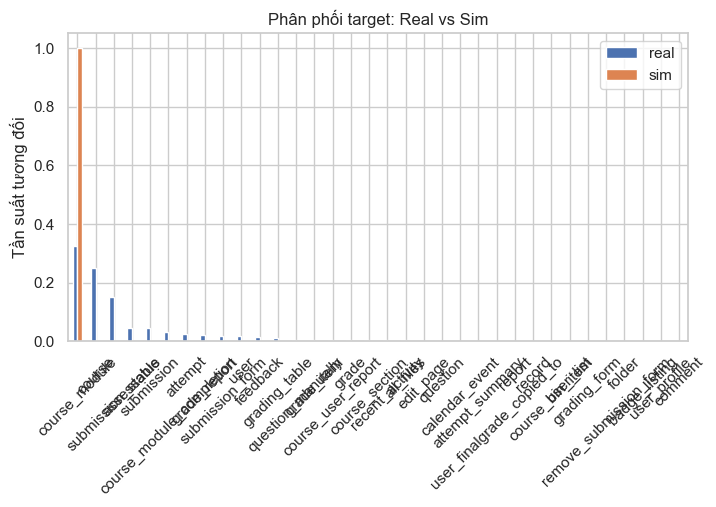

🔹 JS divergence (target) = inf



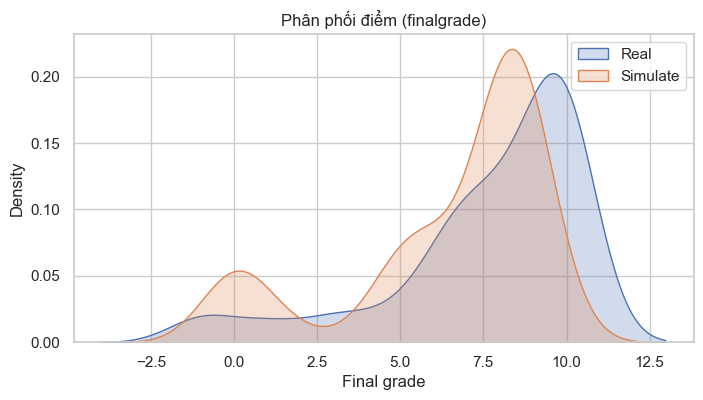

📈 KS-test finalgrade: statistic=0.4629, p=0.0000
📊 Trung bình điểm: real=7.64, sim=6.47



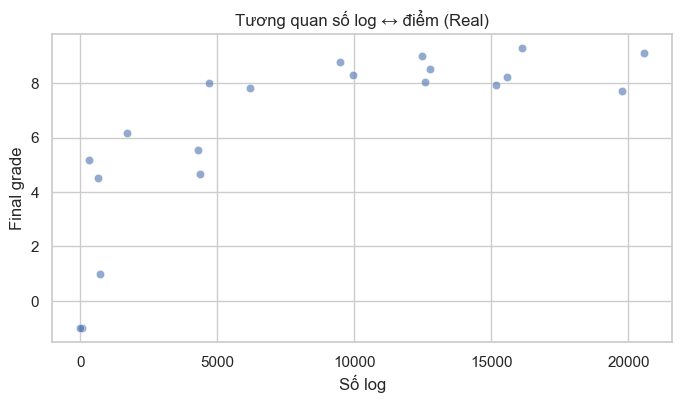

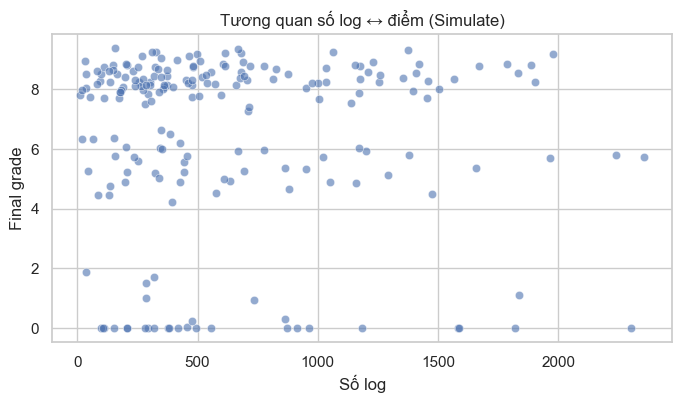

🔗 Hệ số tương quan:
 - Real: 0.7504
 - Simulate: -0.0297

📋 Tổng hợp so sánh:
 - KS_user_events: 0.17636363636363636
 - KS_grade: 0.4628969957081545
 - Corr_real: 0.750377968541762
 - Corr_sim: -0.02967710373476179
 - Num_users_real: 22
 - Num_users_sim: 200
 - Num_events_real: 13995
 - Num_events_sim: 127760
 - Num_grades_real: 233
 - Num_grades_sim: 200


In [2]:
# 📊 So sánh phân phối dataset gốc vs simulate (GMM) — bản FIX lỗi index=set
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, entropy
import numpy as np

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,4)

# --- Đường dẫn ---
log_real = "../data/udk_moodle_log_course_670.csv"
grade_real = "../data/udk_moodle_grades_course_670.csv"

log_sim = "../simulate_v3/synthetic_logs.csv"
grade_sim = "../simulate_v3/synthetic_grades.csv"

# --- Đọc dữ liệu ---
real_logs = pd.read_csv(log_real)
real_grades = pd.read_csv(grade_real)
sim_logs = pd.read_csv(log_sim)
sim_grades = pd.read_csv(grade_sim)

print("✅ Loaded:")
print(f" - Real logs: {len(real_logs)} rows")
print(f" - Sim logs:  {len(sim_logs)} rows")
print(f" - Real grades: {len(real_grades)} rows")
print(f" - Sim grades:  {len(sim_grades)} rows\n")

# --- Làm sạch cơ bản ---
for df in [real_logs, sim_logs, real_grades, sim_grades]:
    if "userid" in df.columns:
        df.dropna(subset=["userid"], inplace=True)
        df["userid"] = df["userid"].astype(int)

# ============================================================
# 1️⃣ So sánh phân phối số lượng event / user
# ============================================================
real_counts = real_logs.groupby("userid")["id"].count()
sim_counts = sim_logs.groupby("userid")["id"].count()

plt.figure()
sns.kdeplot(real_counts, label="Real", fill=True)
sns.kdeplot(sim_counts, label="Simulate", fill=True)
plt.title("Phân phối số lượng event / user")
plt.xlabel("Số event")
plt.ylabel("Mật độ")
plt.legend()
plt.show()

# KS-test
ks_user = ks_2samp(real_counts, sim_counts)
print(f"📈 KS-test event/user: statistic={ks_user.statistic:.4f}, p={ks_user.pvalue:.4f}")
print(f"📊 Trung bình event/user: real={real_counts.mean():.2f}, sim={sim_counts.mean():.2f}\n")

# ============================================================
# 2️⃣ So sánh phân phối eventname / action / target
# ============================================================
def compare_categorical(col):
    real_vc = real_logs[col].value_counts(normalize=True)
    sim_vc = sim_logs[col].value_counts(normalize=True)
    all_keys = sorted(set(real_vc.index) | set(sim_vc.index))  # ✅ FIX: dùng list thay vì set
    
    df_cmp = pd.DataFrame({
        "real": [real_vc.get(k,0) for k in all_keys],
        "sim": [sim_vc.get(k,0) for k in all_keys]
    }, index=all_keys).sort_values("real", ascending=False)

    df_cmp.plot(kind="bar", figsize=(8,4), title=f"Phân phối {col}: Real vs Sim", rot=45)
    plt.ylabel("Tần suất tương đối")
    plt.show()

    # Jensen–Shannon divergence (symmetrized KL)
    js_div = 0.5 * (entropy(df_cmp["real"], df_cmp["sim"]) + entropy(df_cmp["sim"], df_cmp["real"]))
    print(f"🔹 JS divergence ({col}) = {js_div:.4f}\n")

compare_categorical("eventname")
compare_categorical("action")
compare_categorical("target")

# ============================================================
# 3️⃣ So sánh phân phối điểm (finalgrade)
# ============================================================
plt.figure()
sns.kdeplot(real_grades["finalgrade"], label="Real", fill=True)
sns.kdeplot(sim_grades["finalgrade"], label="Simulate", fill=True)
plt.title("Phân phối điểm (finalgrade)")
plt.xlabel("Final grade")
plt.legend()
plt.show()

ks_grade = ks_2samp(real_grades["finalgrade"], sim_grades["finalgrade"])
print(f"📈 KS-test finalgrade: statistic={ks_grade.statistic:.4f}, p={ks_grade.pvalue:.4f}")
print(f"📊 Trung bình điểm: real={real_grades['finalgrade'].mean():.2f}, sim={sim_grades['finalgrade'].mean():.2f}\n")

# ============================================================
# 4️⃣ So sánh tương quan giữa hoạt động và điểm
# ============================================================
real_merged = pd.merge(real_logs, real_grades[["userid","finalgrade"]], on="userid", how="inner")
sim_merged  = pd.merge(sim_logs,  sim_grades[["userid","finalgrade"]], on="userid", how="inner")

def plot_corr(df, name):
    agg = df.groupby("userid").agg(num_events=("id","count"), finalgrade=("finalgrade","mean")).reset_index()
    corr = agg["num_events"].corr(agg["finalgrade"])
    sns.scatterplot(data=agg, x="num_events", y="finalgrade", alpha=0.6)
    plt.title(f"Tương quan số log ↔ điểm ({name})")
    plt.xlabel("Số log")
    plt.ylabel("Final grade")
    plt.show()
    return corr

corr_real = plot_corr(real_merged, "Real")
corr_sim  = plot_corr(sim_merged, "Simulate")

print(f"🔗 Hệ số tương quan:")
print(f" - Real: {corr_real:.4f}")
print(f" - Simulate: {corr_sim:.4f}\n")

# ============================================================
# 5️⃣ Tổng hợp nhanh kết quả
# ============================================================
summary = {
    "KS_user_events": ks_user.statistic,
    "KS_grade": ks_grade.statistic,
    "Corr_real": corr_real,
    "Corr_sim": corr_sim,
    "Num_users_real": real_logs['userid'].nunique(),
    "Num_users_sim": sim_logs['userid'].nunique(),
    "Num_events_real": len(real_logs),
    "Num_events_sim": len(sim_logs),
    "Num_grades_real": len(real_grades),
    "Num_grades_sim": len(sim_grades)
}
print("📋 Tổng hợp so sánh:")
for k,v in summary.items():
    print(f" - {k}: {v}")
